In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
ls8 = pd.read_excel('./LS8_cornerPts.xlsx')

In [3]:
ls8

,path,row,lat_CTR,lon_CTR,lat_UL,lon_UL,lat_UR,lon_UR,lat_LL,lon_LL,lat_LR,lon_LR
0,1,1,80.774791,3.210620,81.923,5.424,80.307,9.947,81.107,-4.125,79.617,1.472
1,1,2,80.021757,-4.274059,81.203,-3.207,79.699,2.307,80.211,-11.194,78.838,-5.129
2,1,3,79.129883,-10.647337,80.322,-10.432,78.936,-4.404,79.196,-17.039,77.937,-10.831
3,1,4,78.130377,-16.029408,79.320,-16.409,78.048,-10.207,78.095,-21.873,76.940,-15.728
4,1,5,77.048078,-20.572231,78.227,-21.351,77.061,-15.193,76.927,-25.898,75.867,-19.930
...,...,...,...,...,...,...,...,...,...,...,...,...
57778,233,244,81.352691,28.155956,81.848,35.646,80.245,30.979,82.435,24.538,80.730,21.560
57779,233,245,81.718750,18.566867,82.387,25.777,80.691,22.590,82.696,13.461,80.942,12.495
57780,233,246,81.844418,8.404287,82.680,14.794,80.929,13.576,82.680,2.015,80.929,3.233
57781,233,247,81.718750,-1.758293,82.696,3.347,80.942,4.314,82.387,-8.969,80.691,-5.781


In [ ]:
def bearing(lat1,lon1, lat2,lon2):
    """assumes lat/lon values are in decimal degrees"""
    lat1 = lat1*np.pi/180.
    lat2 = lat2*np.pi/180.
    lon1 = lon1*np.pi/180.
    lon2 = lon2*np.pi/180.
    
    X = np.cos(lat2) * np.sin(lon2 - lon1)
    Y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(lon2-lon1)
    
    

Let $C$ be the center point and $\theta$ is the tilt angle there is a corresponding "unit tangent vector" to the sphere with that tilt. Call this vector $v$.

To move $C$ along $v$ a distance $D$ in a sphere of radius $R$ is something like

$$
P_1  = \cos(A) \cdot C + R\cdot \sin (A) \cdot v
$$
where $A$ corresponds to 90km in radians. This is `midpt_1` in code below. Moving in the direction $-v$
yields
$$
P_2  = \cos(A) \cdot C - R\cdot \sin (A) \cdot v
$$
which is referred to as `midpt_2` below.

In [7]:
import numpy as np
import functools 
lat_deg, lon_deg = 77.875, -20.975
lat, lon, R, theta = lat_deg*(2*np.pi)/360, lon_deg*(2*np.pi)/360, 6371, -70 * 2 * np.pi / 360
boulder_lat, boulder_lon = lat, lon
x, y, z = (R * np.cos(lat) * np.sin(lon), R * np.cos(lat) * np.cos(lon), R * np.sin(lat))
C = np.array([x,y,z])

## Computing $v$ from $\theta$

At a point $C=[x,y,z]$, a tilt can be thought of as moving through lat and lon along a line with direction vector $d=(d_lon, d_lat)$, so we have 
in parameters $t$
$$
x(t), y(t), z(t) = (R * \cos(lat_0 + t dlat) * \cos(lon_0 + t dlon), R * \cos(lat_0 + t dlat) * \sin(lon_0 + t dlon), R * \sin(lat_0 + t dlat))
$$

Differentiating with respect to $t$
(ignoring the $R$ scaling as we want normalized $v$) we see $v$ is parallel
to 
$$
R\cdot (-\sin (lat_0) \cos(lon_0) dlat - \cos(lat_0) \sin(lon_0) dlon, -\sin(lat_0) \sin(lon_0) dlat + \cos(lat_0) \cos(lon_0) dlon, \cos(lat_0) dlat)
$$

In [8]:
dlat, dlon = np.sin(theta), np.cos(theta)
v = np.array([-np.sin(lat) * np.sin(lon) * dlat + np.cos(lat) * np.cos(lon) * dlon,
              -np.sin(lat) * np.cos(lon) * dlat - np.cos(lat) * np.sin(lon) * dlon,
              np.cos(lat) * dlat])
v /= np.linalg.norm(v) 
np.sum(v*C)

0.0

The angle $A$ is 
$$
\frac{A}{2\pi} = \frac{90km}{2 \pi \cdot 6371km}
$$

In [9]:
A = 90/R
A

0.014126510751844295

In [10]:
midpt_1 = np.cos(A) * C + R * np.sin(A) * v
np.linalg.norm(midpt_1 - C), np.dot(midpt_1, C) / R**2, np.cos(A)

(89.9992516582193, 0.9999002225062911, 0.9999002225062912)

To find next corner, we move $\perp$ to $v$.
That direction can be found by
$$
v \times P_1.
$$
Let $v^{\perp}$ be the unit vector in this direction.

In [11]:
v_perp = np.cross(midpt_1, v) # == np.cross(C, v)
v_perp /= np.linalg.norm(v_perp)
v_perp

array([-0.95769775, -0.28733023, -0.01601127])

We will then move 92.5km from $P_1$ in the direction 
$$
P_2 = \cos(B) \cdot P_1 + R \cdot \sin(B) \cdot v^{\perp}
$$
where
$$
\frac{B}{2\pi} = \frac{92.5km}{6371km}
$$

In [12]:
B = 92.5/6371
corners = [np.cos(B) * midpt_1 + R * np.sin(B) * v_perp]
corners.append(np.cos(B) * midpt_1 - R * np.sin(B) * v_perp)

v_perp = np.cross(midpt_1, v) # == np.cross(C, v)
v_perp /= np.linalg.norm(v_perp)
v_perp
midpt_2 = np.cos(A) * C - R * np.sin(A) * v
corners.append(np.cos(B) * midpt_2 + R * np.sin(B) * v_perp)
corners.append(np.cos(B) * midpt_2 - R * np.sin(B) * v_perp)

corners

[array([-592.50445431, 1307.05760939, 6207.2683104 ]),
 array([-415.33659543, 1360.21183452, 6210.23029184]),
 array([-542.51096281, 1138.32435259, 6244.96121073]),
 array([-365.34310393, 1191.47857771, 6247.92319217])]

In [13]:
[np.linalg.norm(corner) for corner in corners]

[6370.999999999999, 6370.999999999999, 6371.000000000001, 6371.0]

We can find another corner
$$
\cos(A') \cdot P_1 - R \cdot \sin(A') \cdot v^{\perp}
$$ 
and similarly other corners.

### Now convert back to lat lon

In [14]:
lat_degs = [np.arcsin(z_ / R) / (2 * np.pi) * 360 for x_, y_, z_ in corners]
lat_degs

[76.98228647840101, 77.10107655680675, 78.58424793008591, 78.71962386426219]

In [15]:
lon_degs = [np.arctan2(x_ / R, y_ / R) / (2 * np.pi) * 360 for x_, y_, z_ in corners]
lon_degs

[-24.385340987196802,
 -16.979893384135025,
 -25.481877244698317,
 -17.047111911561473]

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

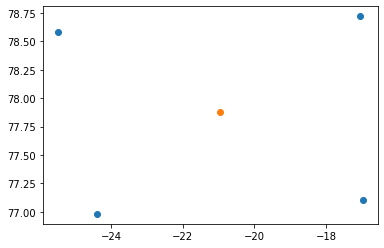

In [17]:
plt.scatter(lon_degs, lat_degs)
plt.scatter([lon_deg], [lat_deg])

In [12]:
boulder_scenes = np.array([[1.82882079, 0.72884239],
                           [1.83717104, 0.75371663],
                           [1.83235034, 0.65405287],
                           [1.83991762, 0.6790087 ],
                           [1.82075591, 0.70393913],
                           [1.84772238, 0.70393913],
                           [1.85578727, 0.72884239]])

In [13]:
lon, lat

(1.8373081035744305, 0.6981317007977318)

### A representation of the scene that implements `contains`

In [14]:

def representation(center_lon,  # in radians
                   center_lat,  # in radians
                   instrument_tilt, # in degrees, rotation clockwise
                   len_lon=180, # extent in km
                   len_lat=185, # extent in km
                   R=6371):      # "radius" of earth

    tilt_deg = instrument_tilt * 2 * np.pi / 360

    x, y, z = (R * np.cos(center_lat) *
               np.sin(center_lon),
               R * np.cos(center_lat) *
               np.cos(center_lon), R * np.sin(center_lat))
    C = np.array([x,y,z]) # center of scene

    dlat, dlon = np.sin(-tilt_deg), np.cos(-tilt_deg)
    dir_lon = np.array([-np.sin(center_lat) * np.sin(center_lon) * dlat +
                       np.cos(center_lat) * np.cos(center_lon) * dlon,
                       -np.sin(center_lat) * np.cos(center_lon) * dlat -
                       np.cos(center_lat) * np.sin(center_lon) * dlon,
                       np.cos(center_lat) * dlat])
    dir_lon /= np.linalg.norm(dir_lon) 

    A = len_lon / 2 / R
    midpt_1 = np.cos(A) * C + R * np.sin(A) * dir_lon

    dir_lat = np.cross(midpt_1, dir_lon)
    dir_lat /= np.linalg.norm(dir_lat)

    B = len_lat/ 2 / R

    corners = [np.cos(B) * midpt_1 + R * np.sin(B) * dir_lat]
    corners.append(np.cos(B) * midpt_1 - R * np.sin(B) * dir_lat)

    midpt_2 = np.cos(A) * C - R * np.sin(A) * dir_lon
    corners.append(np.cos(B) * midpt_2 + R * np.sin(B) * dir_lat)
    corners.append(np.cos(B) * midpt_2 - R * np.sin(B) * dir_lat)
    corners = np.array(corners)
    
    corners_lon_lat = np.array([(np.arctan2(x_ / R, y_ / R),
                                 np.arcsin(z_ / R)) for x_, y_, z_ in corners])

    # now work out halfspace

    # these are the edge segmentsin lon/lat space
    supports = [corners_lon_lat[0]-corners_lon_lat[1],
                corners_lon_lat[0]-corners_lon_lat[2],
                corners_lon_lat[1]-corners_lon_lat[3],
                corners_lon_lat[2]-corners_lon_lat[3]] 

    # normals to each edge segment
    normals = np.array([(s[1],-s[0]) for s in supports])
    pts = [corners_lon_lat[0],   # a point within each edge
           corners_lon_lat[0],
           corners_lon_lat[1],
           corners_lon_lat[3]]
    bdry_values = np.array([np.sum(n * p) for n, p in zip(normals, pts)])
    center_values = [np.sum(n * [center_lon, center_lat]) for n in normals]
    center_signs = np.sign(center_values - bdry_values)

    def _check(normals, center_signs, bdry_values, lon_lat_vals):
        normal_mul = np.asarray(lon_lat_vals).dot(normals.T)
        values_ = normal_mul - bdry_values[None,:]
        signs_ = np.sign(values_) * center_signs[None,:]
        return np.squeeze(np.all(signs_ == 1, 1))

    _check = functools.partial(_check, normals, center_signs, bdry_values)
        
    return corners_lon_lat, _check, normals, bdry_values, center_signs


## All scenes containing Boulder

(1.8373081035744305, 0.6981317007977318)

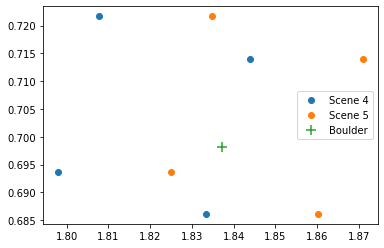

In [15]:
for i, scene in enumerate(boulder_scenes):
    lon, lat = scene
    corners, contains, normals, bdry_values, center_signs = representation(lon, 
                                                                           lat,
                                                                           -theta*360/(2*np.pi))
    
    if contains([boulder_lon, boulder_lat]):
        plt.scatter(corners[:,0], corners[:,1], label='Scene %d' % i)
    
plt.scatter([boulder_lon], [boulder_lat], marker='+', label='Boulder', s=100)
plt.legend()
    
boulder_lon, boulder_lat

### What needs to be stored

- We need to store `normals`, `bdry_values` and `center_signs` for each scene.

### How `contains` is determined

- Function can check several query points at once....


In [16]:
def _check(normals, center_signs, bdry_values, lon_lat_vals):
    normal_mul = np.asarray(lon_lat_vals).dot(normals.T)
    values_ = normal_mul - bdry_values[None,:]
    signs_ = np.sign(values_) * center_signs[None,:]
    return np.squeeze(np.all(signs_ == 1, 1))
import functools

contains = functools.partial(_check, normals, center_signs, bdry_values)

### Scenes not containing Boulder

(1.8373081035744305, 0.6981317007977318)

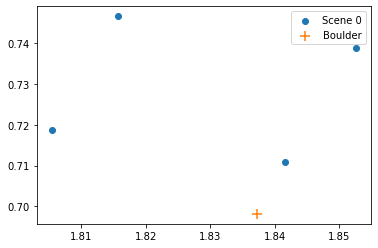

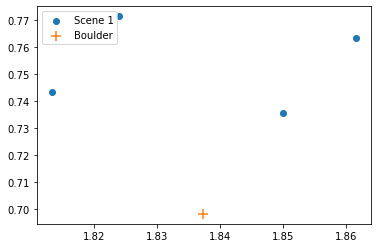

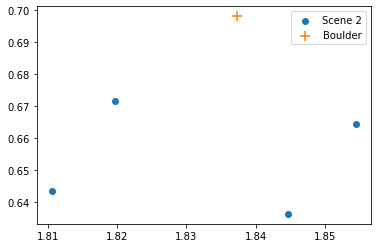

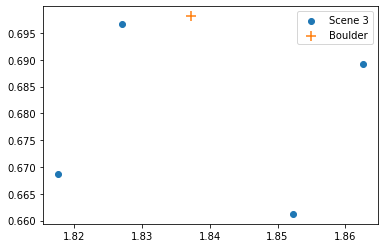

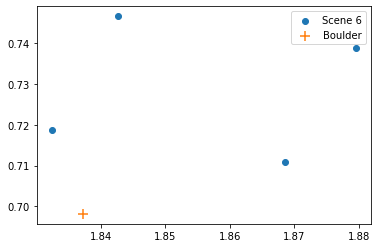

In [17]:
for i, scene in enumerate(boulder_scenes):
    lon, lat = scene
    corners, contains, normals, bdry_values, center_signs = representation(lon, 
                                                                           lat,
                                                                           -theta*360/(2*np.pi))
    
    if not contains([boulder_lon, boulder_lat]):
        plt.figure()
        plt.scatter(corners[:,0], corners[:,1], label='Scene %d' % i)
        plt.scatter([boulder_lon], [boulder_lat], marker='+', label='Boulder', s=100)
        plt.legend()
    
boulder_lon, boulder_lat